In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

### Load data (pre-processed in clean.ipynb) and define useful constants

In [37]:
# load data
res = pd.read_csv("results/results_cleaned.csv")

# required fields
ids = ['timestamp','postId','workerId','mode']

# interactions
inter = ['timestamp','postId','workerId','mode','interaction','UrlChanges', 'highUrlChanges', 
       'lowUrlChanges', 'medUrlChanges', 'model', 'pop_time']

modes = ["List", "Category", "Pairwise"]

In [38]:
# compute bootstrapped confidence interval
def bootstrap_mean(data, n_bootstraps):
    bootstraps = []
    for i in range(n_bootstraps):
        # Sample with replacement from data
        bootstraps.append(resample(data).mean())
    return pd.Series(bootstraps)

In [39]:
# # should we change the interactions to just be add remove? 
# # can tell by url if high low etc

# res.replace(to_replace=['ADD', 'HIGH ADD', 'LOW ADD', 'LEFT ADD', 'RIGHT ADD'], value ='ADD', inplace=True)
# res.replace(to_replace=['REMOVE', 'HIGH REMOVE', 'LOW REMOVE', 'LEFT REMOVE', 'RIGHT REMOVE'], value ='REMOVE', inplace=True)

In [40]:
inter_l = ['timestamp','workerId','mode','interaction','UrlChanges'] 
inter_c = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges', 'medUrlChanges']
inter_p = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges']

ints = {}
ints['l'] = res[inter_l][res['mode']=='List'].drop_duplicates(subset=['workerId','interaction','UrlChanges'])
ints['c'] = res[inter_c][res['mode']=='Category'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges', 'medUrlChanges'])
ints['p'] = res[inter_p][res['mode']=='Pairwise'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges'])

In [41]:
adds={}
removes={}
ranks = {}
for i in ints:
    ints[i] = ints[i].groupby(['workerId']).apply(pd.DataFrame.sort_values, 'timestamp')
    ints[i] = ints[i].reset_index(drop=True)
    ints[i].dropna(subset =['interaction'])

In [42]:
adds = {}
adds['List'] = ints['l'][ints['l']['interaction'] == 'ADD'].groupby('workerId').count()['interaction']
adds['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW ADD', 'HIGH ADD', 'MED ADD'])].groupby('workerId').count()['interaction']
adds['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT ADD', 'RIGHT ADD'])].groupby('workerId').count()['interaction']

removes = {}
removes['List'] = ints['l'][ints['l']['interaction'] == 'REMOVE'].groupby('workerId').count()['interaction']
removes['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW REMOVE', 'HIGH REMOVE', 'MED REMOVE'])].groupby('workerId').count()['interaction']
removes['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT REMOVE', 'RIGHT REMOVE'])].groupby('workerId').count()['interaction']

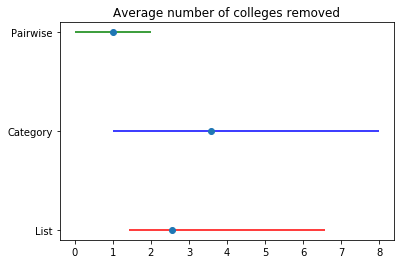

In [49]:
boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(removes[m], 1000)
    
mean = boot.mean()
err = []
err.append(boot.apply(lambda x : np.percentile(x, (5))))
err.append(boot.apply(lambda x : np.percentile(x, (95))))
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'])
plt.yticks([0,1,2], mean.index)
plt.title('Average number of colleges removed')
# plt.show()
plt.savefig('results/remove.png')

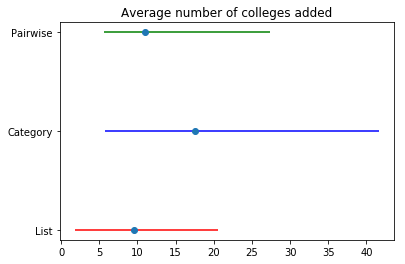

In [56]:
# use percentiles

boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(adds[m], 1000)
mean = boot.mean()
err = []
err.append(boot.apply(lambda x : np.percentile(x, (5))))
err.append(boot.apply(lambda x : np.percentile(x, (95))))
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'])
plt.yticks([0,1,2], mean.index)
plt.title('Average number of colleges added')
# plt.show()
plt.savefig('results/add.png')

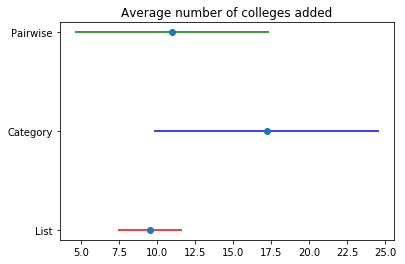

In [55]:
# use stdev

boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(adds[m], 1000)
mean = boot.mean()
std = boot.std()
plt.errorbar(mean, [0,1,2], xerr=2*std, fmt='o-',linestyle='none', ecolor=['red','blue','green'])
plt.yticks([0,1,2], mean.index)
plt.title('Average number of colleges added')
# plt.show()
plt.savefig('results/add.png')